In [1]:
import numpy as np
from scipy.special import expit, logit
from shap.maskers import Independent
from plots import plot_shap_value_distribution, plot_shap_partial_dependence, plot_shap_values_stacked, \
    plot_shap_values_hierarchically_clustered, plot_functions
import shap
import matplotlib.pyplot as plt
%matplotlib inline
shap.initjs()

# Move Soft Decision Boundary

## Create Models

In [2]:
f1 = lambda X: np.clip(X[:,0] * 50, -5, 5)
f1.title = ''
f2 = lambda X: np.clip((X[:,0] - 0.15) * 50, -5, 5)

c1 = lambda X: expit(f1(X))
c2 = lambda X: expit(f2(X))

In [3]:
x_from = -1
x_to = 1
feature_names = ['x1']
num_samples = 500
x1 = np.linspace(x_from, x_to, num_samples)
X = np.reshape(x1, (num_samples, len(feature_names)))

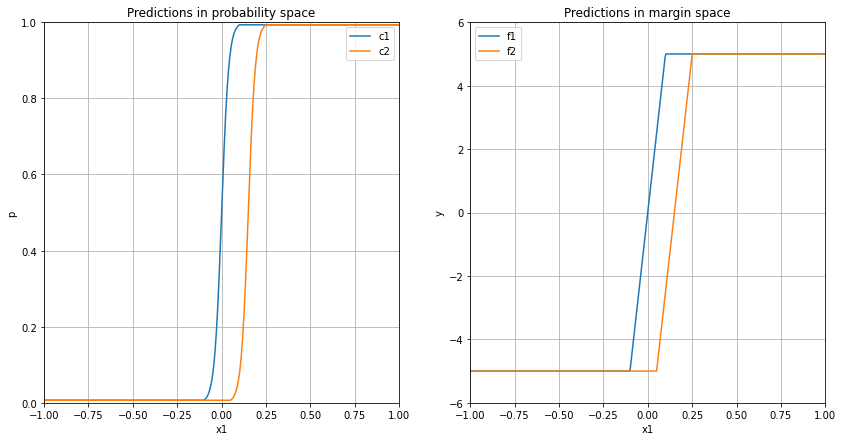

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
plot_functions(X, {'c1': c1, 'c2': c2}, 'Predictions in probability space', 'x1', 'p', (x_from, x_to), (0, 1), axs[0])
plot_functions(X, {'f1': f1, 'f2': f2}, 'Predictions in margin space', 'x1', 'y', (x_from, x_to), (-6, 6), axs[1])
plt.show()

In [5]:
complement = lambda p: 1 - p
c1_positive_and_c2_negative = lambda p1, p2: p1 * complement(p2)
c1_negative_and_c2_positive = lambda p1, p2: complement(p1) * p2
c1_and_c2_different = lambda p1, p2: c1_positive_and_c2_negative(p1, p2) + c1_negative_and_c2_positive(p1, p2)

c_c1_positive_and_c2_negative = lambda X: c1_positive_and_c2_negative(c1(X), c2(X))
c_c1_negative_and_c2_positive = lambda X: c1_negative_and_c2_positive(c1(X), c2(X))
c_c1_and_c2_different = lambda X: c1_and_c2_different(c1(X), c2(X))

In [6]:
odds = lambda p: p / complement(p)
log_odds_ratio_from_proba = lambda p1, p2: np.log(odds(p1) / odds(p2))
log_odds_ratio = lambda y1, y2: y1 - y2

f_c1_positive_and_c2_negative = lambda X: logit(c_c1_positive_and_c2_negative(X))
f_c1_negative_and_c2_positive = lambda X: logit(c_c1_negative_and_c2_positive(X))
f_c1_and_c2_different = lambda X: logit(c_c1_and_c2_different(X))
f_log_odds_ratio = lambda X: log_odds_ratio(f1(X), f2(X))

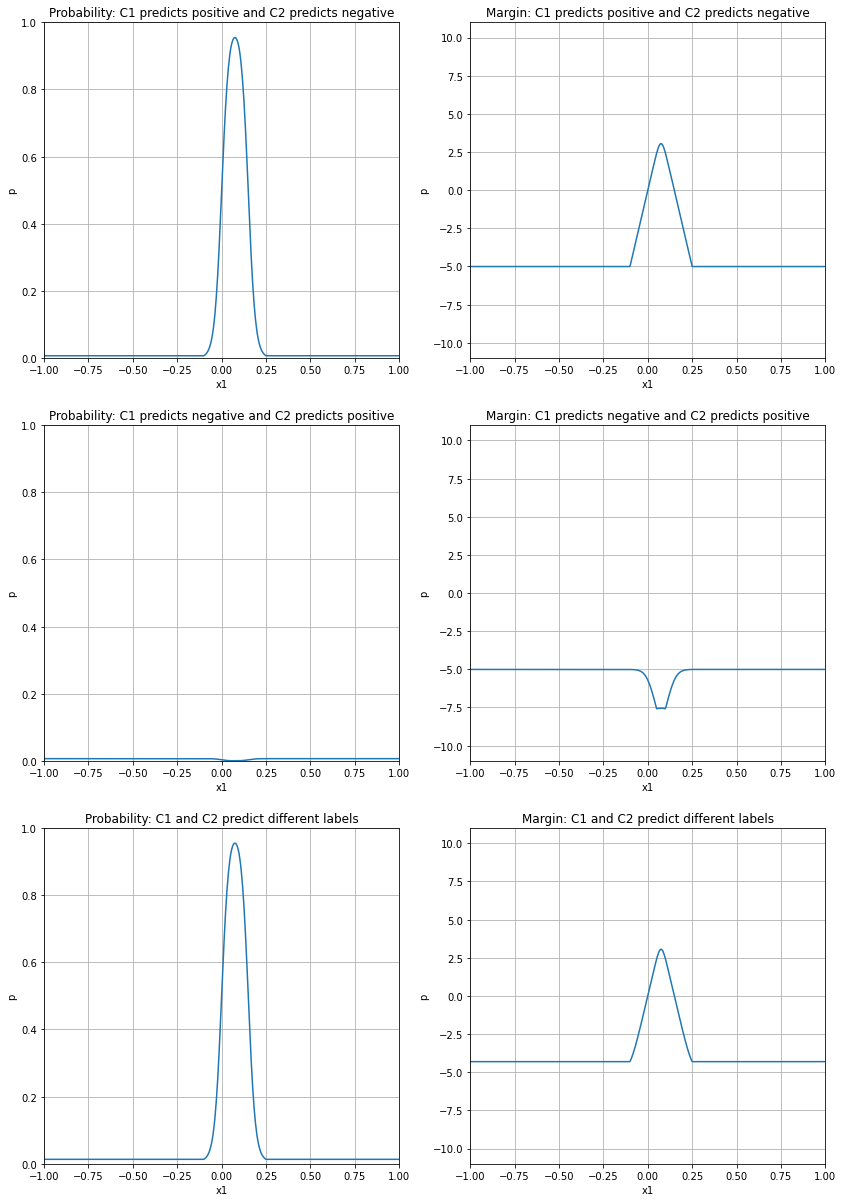

In [7]:
fig, axs = plt.subplots(3, 2, figsize=(14, 21))
plot_functions(X, c_c1_positive_and_c2_negative, 'Probability: C1 predicts positive and C2 predicts negative', 'x1', 'p', (x_from, x_to), (0, 1), axs[0,0])
plot_functions(X, c_c1_negative_and_c2_positive, 'Probability: C1 predicts negative and C2 predicts positive', 'x1', 'p', (x_from, x_to), (0, 1), axs[1,0])
plot_functions(X, c_c1_and_c2_different, 'Probability: C1 and C2 predict different labels', 'x1', 'p', (x_from, x_to), (0, 1), axs[2,0])
plot_functions(X, f_c1_positive_and_c2_negative, 'Margin: C1 predicts positive and C2 predicts negative', 'x1', 'p', (x_from, x_to), (-11, 11), axs[0,1])
plot_functions(X, f_c1_negative_and_c2_positive, 'Margin: C1 predicts negative and C2 predicts positive', 'x1', 'p', (x_from, x_to), (-11, 11), axs[1,1])
plot_functions(X, f_c1_and_c2_different, 'Margin: C1 and C2 predict different labels', 'x1', 'p', (x_from, x_to), (-11, 11), axs[2,1])
plt.show()

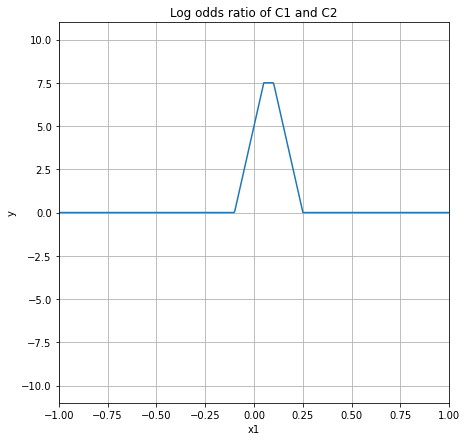

In [8]:
plot_functions(X, f_log_odds_ratio, 'Log odds ratio of C1 and C2', 'x1', 'y', (x_from, x_to), (-11, 11))

## Generate Explanations

In [8]:
def make_shap_values(model, background_data, feature_names):
    masker = Independent(background_data)
    explainer = shap.Explainer(model, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_c1 = make_shap_values(c1, X, feature_names)
shap_values_c2 = make_shap_values(c2, X, feature_names)
shap_values_f1 = make_shap_values(f1, X, feature_names)
shap_values_f2 = make_shap_values(f2, X, feature_names)

In [9]:
shap_values_c_c1_positive_and_c2_negative = make_shap_values(c_c1_positive_and_c2_negative, X, feature_names)
shap_values_c_c1_negative_and_c2_positive = make_shap_values(c_c1_negative_and_c2_positive, X, feature_names)
shap_values_c_c1_and_c2_different = make_shap_values(c_c1_and_c2_different, X, feature_names)
shap_values_f_c1_positive_and_c2_negative = make_shap_values(f_c1_positive_and_c2_negative, X, feature_names)
shap_values_f_c1_negative_and_c2_positive = make_shap_values(f_c1_negative_and_c2_positive, X, feature_names)
shap_values_f_c1_and_c2_different = make_shap_values(f_c1_and_c2_different, X, feature_names)
shap_values_f_log_odds_ratio = make_shap_values(f_log_odds_ratio, X, feature_names)

## Analyze

### SHAP Value Distribution

#### Probability Space

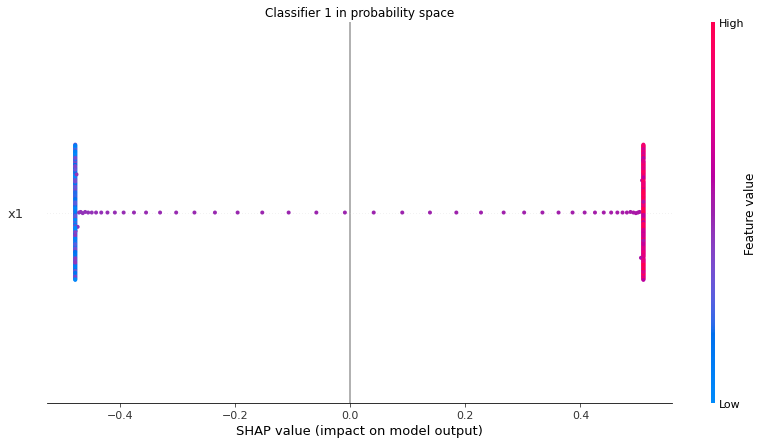

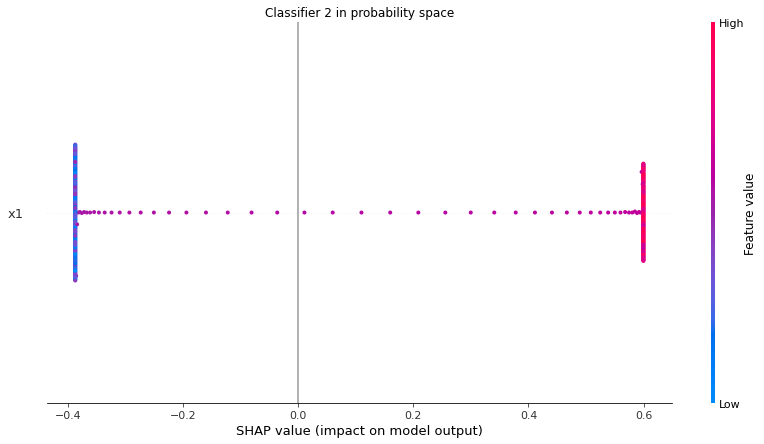

In [11]:
plot_shap_value_distribution(shap_values_c1, 'Classifier 1')
plot_shap_value_distribution(shap_values_c2, 'Classifier 2')

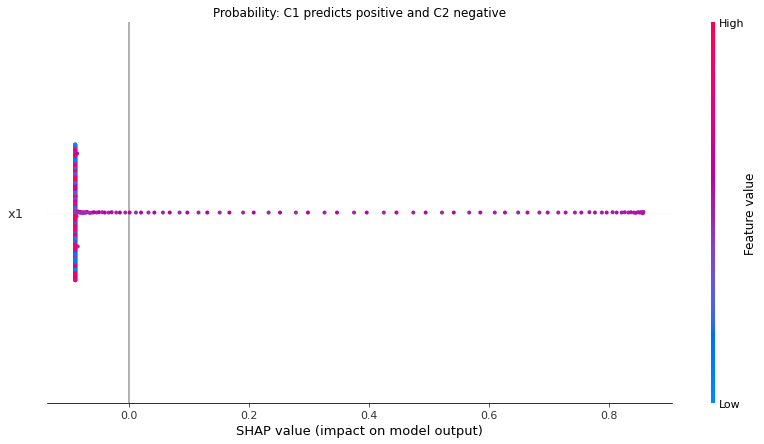

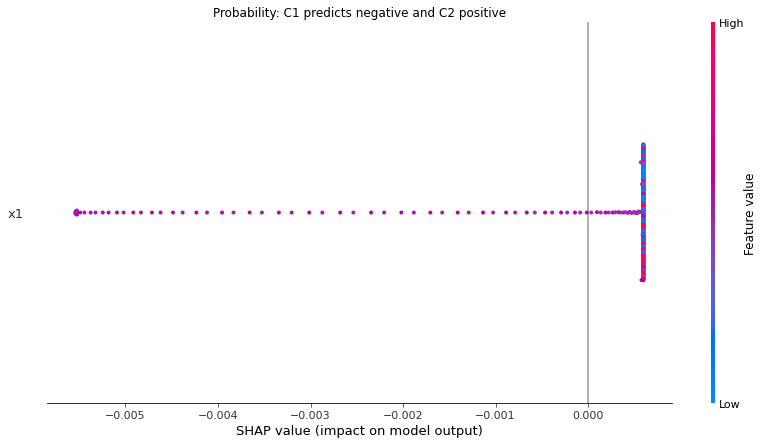

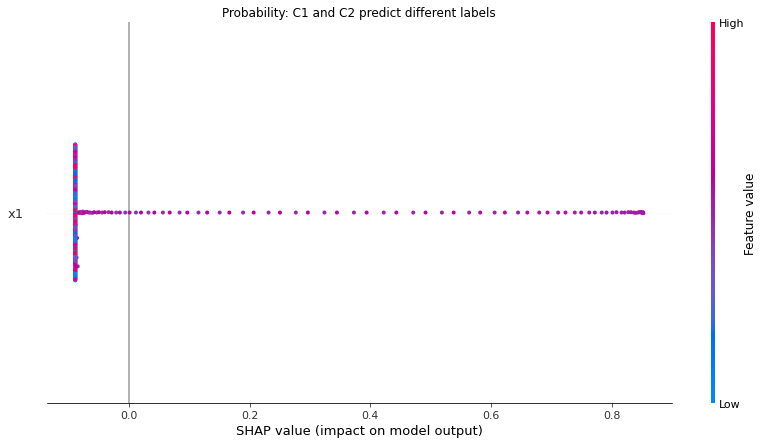

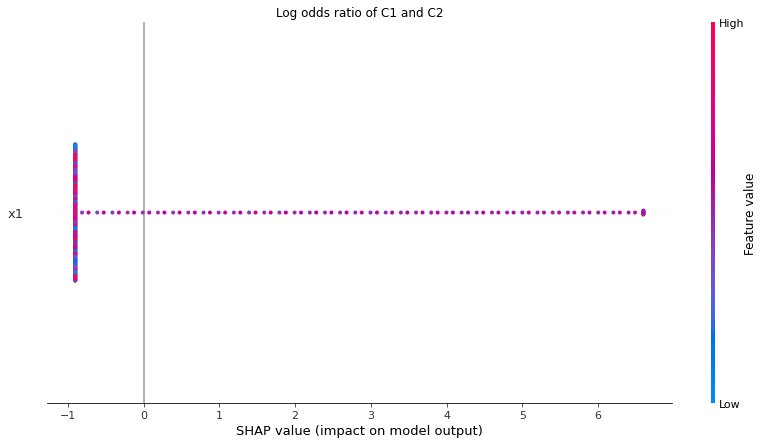

In [12]:
plot_shap_value_distribution(shap_values_c_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_value_distribution(shap_values_c_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_value_distribution(shap_values_c_c1_and_c2_different, 'C1 and C2 predict different labels')

#### Margin Space

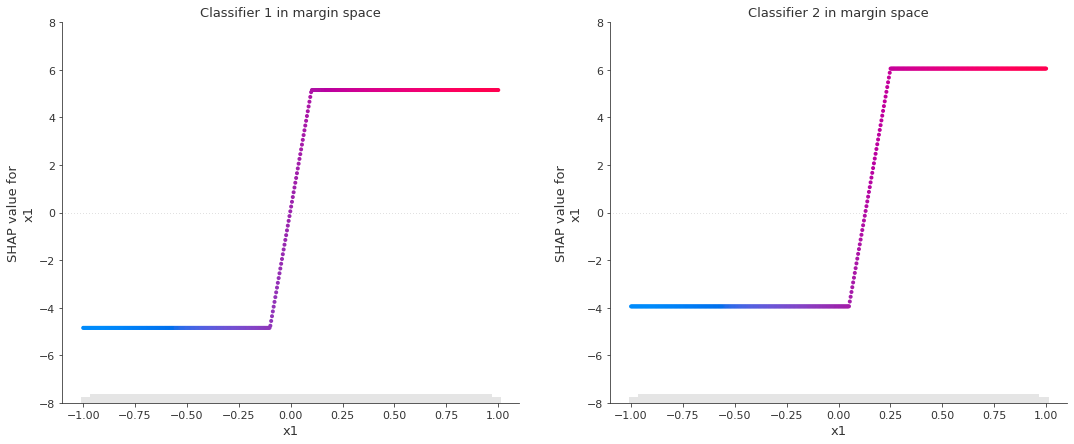

In [13]:
plot_shap_value_distribution(shap_values_f1, 'Classifier 1')
plot_shap_value_distribution(shap_values_f2, 'Classifier 2')

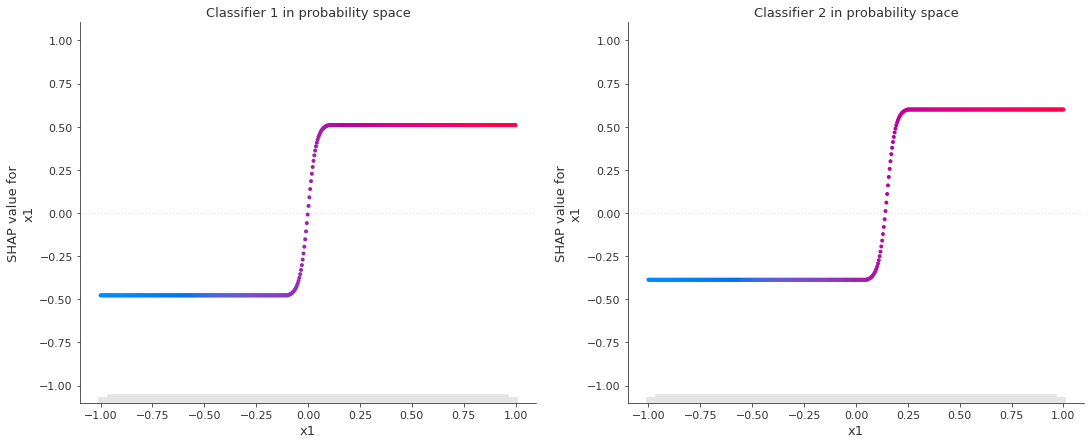

In [14]:
plot_shap_value_distribution(shap_values_f_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_value_distribution(shap_values_f_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_value_distribution(shap_values_f_c1_and_c2_different, 'C1 and C2 predict different labels')

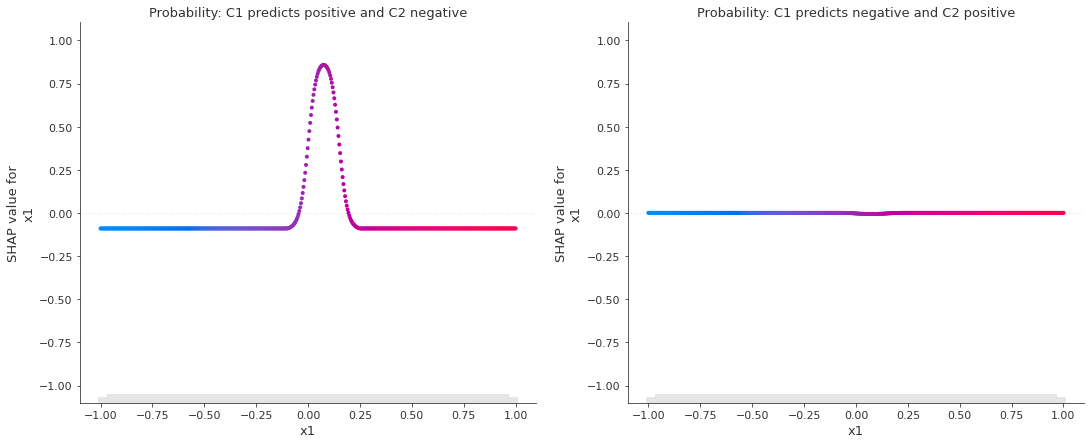

In [15]:
plot_shap_value_distribution(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2')

### Features' Partial Dependence Plots

#### Probability Space

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_c1, feature_names[0], 'Classifier 1', (-1, 1), axs[0])
plot_shap_partial_dependence(shap_values_c2, feature_names[0], 'Classifier 2', (-1, 1), axs[1])
plt.show()

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_c_c1_positive_and_c2_negative, feature_names[0], 'C1 predicts positive and C2 negative', (-1, 1), axs[0])
plot_shap_partial_dependence(shap_values_c_c1_negative_and_c2_positive, feature_names[0], 'C1 predicts negative and C2 positive', (-1, 1), axs[1])
plt.show()

In [19]:
plot_shap_partial_dependence(shap_values_c_c1_and_c2_different, feature_names[0], 'C1 and C2 predict different labels', (-1, 1))

#### Margin Space

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_f1, feature_names[0], 'Classifier 1', (-8, 8), axs[0])
plot_shap_partial_dependence(shap_values_f2, feature_names[0], 'Classifier 2', (-8, 8), axs[1])
plt.show()

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_f_c1_positive_and_c2_negative, feature_names[0], 'C1 predicts positive and C2 negative', (-8, 8), axs[0])
plot_shap_partial_dependence(shap_values_f_c1_negative_and_c2_positive, feature_names[0], 'C1 predicts negative and C2 positive', (-8, 8), axs[1])
plt.show()

In [ ]:
plot_shap_partial_dependence(shap_values_f_c1_and_c2_different, feature_names[0], 'C1 and C2 predict different labels', (-8, 8))

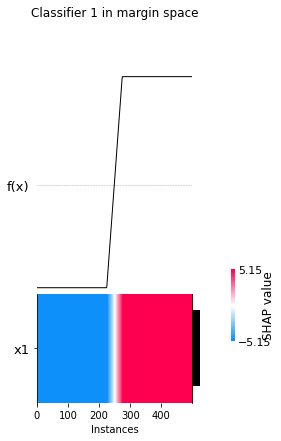

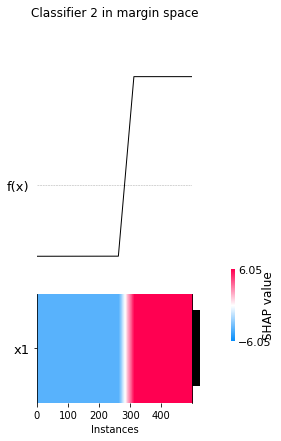

In [23]:
plot_shap_partial_dependence(shap_values_f_log_odds_ratio, feature_names[0], 'Log odds ratio of C1 and C2', (-10, 10))

### Stacked SHAP Explanations, Clustered by Similarity

#### Probability Space

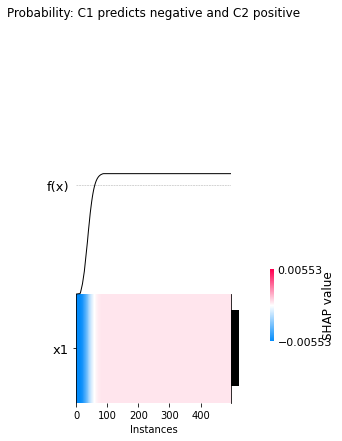

In [26]:
ordering = plot_shap_values_stacked(shap_values_c1, 'Classifier 1')
plot_shap_values_stacked(shap_values_c2, 'Classifier 2', ordering=ordering);

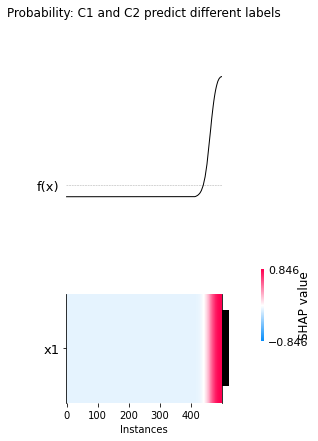

In [27]:
plot_shap_values_stacked(shap_values_c_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_values_stacked(shap_values_c_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_values_stacked(shap_values_c_c1_and_c2_different, 'C1 and C2 predict different labels');

#### Margin Space

In [ ]:
ordering = plot_shap_values_stacked(shap_values_f1, 'Classifier 1')
plot_shap_values_stacked(shap_values_f2, 'Classifier 2', ordering=ordering);

In [ ]:
plot_shap_values_stacked(shap_values_f_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_values_stacked(shap_values_f_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_values_stacked(shap_values_f_c1_and_c2_different, 'C1 and C2 predict different labels');

In [ ]:
plot_shap_values_stacked(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2');

### Hierarchically Clustered SHAP Values

#### Probability Space

In [ ]:
plot_shap_values_hierarchically_clustered(shap_values_c1, 'Classifier 1')
plot_shap_values_hierarchically_clustered(shap_values_c2, 'Classifier 2')

In [ ]:
plot_shap_values_hierarchically_clustered(shap_values_c_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_values_hierarchically_clustered(shap_values_c_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_values_hierarchically_clustered(shap_values_c_c1_and_c2_different, 'C1 and C2 predict different labels')

#### Margin Space

In [ ]:
plot_shap_values_hierarchically_clustered(shap_values_f1, 'Classifier 1')
plot_shap_values_hierarchically_clustered(shap_values_f2, 'Classifier 2')

In [ ]:
plot_shap_values_hierarchically_clustered(shap_values_f_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_values_hierarchically_clustered(shap_values_f_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_values_hierarchically_clustered(shap_values_f_c1_and_c2_different, 'C1 and C2 predict different labels')

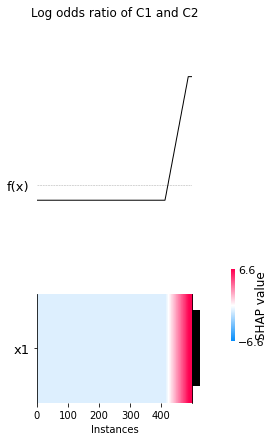

In [28]:
plot_shap_values_hierarchically_clustered(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2')